In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torchvision
import os
from torchvision.utils import save_image
import random
from PIL import Image

In [2]:
categories = {
    "non_demented": "/kaggle/input/imagesoasis/Data/Non Demented",
    "very_mild_demented": "/kaggle/input/imagesoasis/Data/Very mild Dementia",
    "mild_demented": "/kaggle/input/imagesoasis/Data/Mild Dementia",
    "moderate_demented": "/kaggle/input/imagesoasis/Data/Moderate Dementia",
}

# Dictionary to store file paths
image_paths = {category: [] for category in categories}

# Loop through each category and collect file paths
for category, path in categories.items():
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename.lower().endswith(('.jpg', '.png', '.jpeg')):  # Filter valid images
                image_paths[category].append(os.path.join(dirname, filename))

# Print number of images per category
for category, images in image_paths.items():
    print(f"Loaded {len(images)} images for category: {category}")

Loaded 67222 images for category: non_demented
Loaded 13725 images for category: very_mild_demented
Loaded 5002 images for category: mild_demented
Loaded 488 images for category: moderate_demented


In [3]:
import os
import random
import torch
from PIL import Image
from torchvision import transforms

# Define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),  # Converts to 1-channel tensor (C, H, W)
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale pixel values
])

# Paths to image directories
data_root = "/kaggle/input/imagesoasis/Data"
class_A_path = os.path.join(data_root, "Mild Dementia")  # Majority class
class_B_path = os.path.join(data_root, "Moderate Dementia")  # Minority class

# Get image file names
images_A = [os.path.join(class_A_path, img) for img in os.listdir(class_A_path) if img.endswith(('.jpg', '.png', '.jpeg'))]
images_B = [os.path.join(class_B_path, img) for img in os.listdir(class_B_path) if img.endswith(('.jpg', '.png', '.jpeg'))]

# Upsample the minority class (Moderate Dementia) by repeating images
num_images_A = len(images_A)
num_images_B = len(images_B)

# If the minority class has fewer images, upsample it by repeating the images
if num_images_B < num_images_A:
    # Repeat the images from class B until it reaches the number of images in class A
    images_B = images_B * (num_images_A // num_images_B) + random.sample(images_B, num_images_A % num_images_B)

# Function to load and transform grayscale images
def load_image(image_path):
    image = Image.open(image_path).convert("L")  # Convert to grayscale ("L" mode)
    return transform(image)  # Apply transformations

# Load images into tensors (without DataLoader)
tensor_images_A = [load_image(img) for img in images_A]
tensor_images_B = [load_image(img) for img in images_B]

# Convert list of tensors into a single tensor batch
tensor_images_A = torch.stack(tensor_images_A)  # Shape: (num_images_A, 1, 256, 256)
tensor_images_B = torch.stack(tensor_images_B)  # Shape: (num_images_A, 1, 256, 256)

print(f"Class A tensor shape: {tensor_images_A.shape}")
print(f"Class B tensor shape: {tensor_images_B.shape}")

Class A tensor shape: torch.Size([5002, 1, 256, 256])
Class B tensor shape: torch.Size([5002, 1, 256, 256])


Using device: cuda
Epoch [1/10] Loss D: 0.5845, Loss G: 2.2005
Epoch [2/10] Loss D: 0.8418, Loss G: 1.7998
Epoch [3/10] Loss D: 0.6446, Loss G: 2.3285
Epoch [4/10] Loss D: 0.4945, Loss G: 2.2010
Epoch [5/10] Loss D: 0.5725, Loss G: 2.5673
Epoch [6/10] Loss D: 0.5715, Loss G: 2.6335
Epoch [7/10] Loss D: 0.6355, Loss G: 2.6603
Epoch [8/10] Loss D: 0.5906, Loss G: 3.0285
Epoch [9/10] Loss D: 0.4077, Loss G: 2.9685
Epoch [10/10] Loss D: 0.3860, Loss G: 3.5205


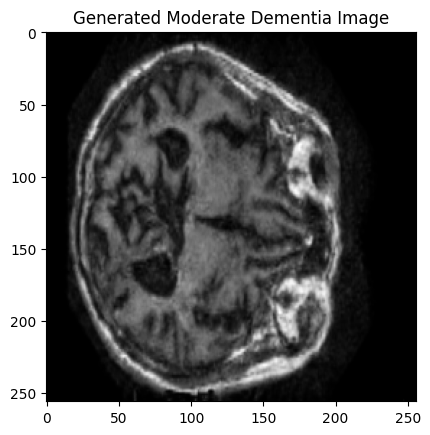

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# Initialize the models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Define loss function and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Move tensors to device
tensor_images_A = tensor_images_A.to(device)
tensor_images_B = tensor_images_B.to(device)

# Training Loop
def train_gan(tensor_images_A, tensor_images_B, num_epochs=100):
    for epoch in range(num_epochs):
        for real_A, real_B in zip(tensor_images_A, tensor_images_B):
            real_A = real_A.unsqueeze(0).to(device)  # Add batch dimension
            real_B = real_B.unsqueeze(0).to(device)  # Add batch dimension

            # Train Discriminator
            optimizer_d.zero_grad()

            # Real B images
            real_labels = torch.ones_like(discriminator(real_B))
            output_real = discriminator(real_B)
            loss_real = criterion(output_real, real_labels)

            # Fake B images
            fake_B = generator(real_A)
            fake_labels = torch.zeros_like(discriminator(fake_B))
            output_fake = discriminator(fake_B.detach())
            loss_fake = criterion(output_fake, fake_labels)

            # Total Discriminator loss
            loss_d = loss_real + loss_fake
            loss_d.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()
            output_fake = discriminator(fake_B)
            loss_g = criterion(output_fake, real_labels)
            loss_g.backward()
            optimizer_g.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")

# Example forward pass
def generate_moderate_dementia(mild_image_tensor):
    generator.eval()
    with torch.no_grad():
        moderate_image = generator(mild_image_tensor.unsqueeze(0).to(device))  # Add batch dimension
    return moderate_image.squeeze(0).cpu()  # Remove batch dimension

# Train for 10 epochs
train_gan(tensor_images_A, tensor_images_B, num_epochs=10)

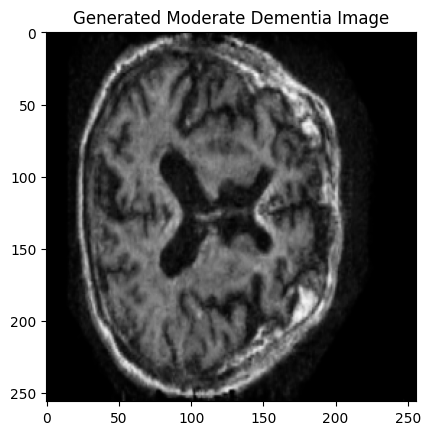

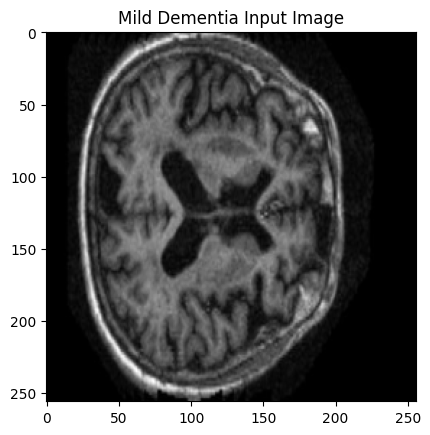

In [21]:
mild_image_tensor = tensor_images_A[9]
moderate_image_tensor = generate_moderate_dementia(mild_image_tensor)

# Plot the generated image
plt.imshow(moderate_image_tensor.squeeze().cpu().numpy(), cmap='gray')
plt.title('Generated Moderate Dementia Image')
plt.show()
# Convert tensor to numpy array and plot
plt.imshow(mild_image_tensor.squeeze().cpu().numpy(), cmap='gray')
plt.title('Mild Dementia Input Image')
plt.show()


In [22]:
# Save the models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

print("Models saved successfully!")

Models saved successfully!


In [23]:
# Load the models
generator.load_state_dict(torch.load('generator.pth'))
discriminator.load_state_dict(torch.load('discriminator.pth'))

# Set models to evaluation mode (optional, for inference)
generator.eval()
discriminator.eval()

print("Models loaded successfully!")


Models loaded successfully!


<ipython-input-23-b0972f476932>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator.pth'))
<ipython-input-23-b0972f476932>:3: Fu